# Setup

In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using Muon
using SPI
using CSV, DataFrames
using NewickTreeTools
using StatsPlots
using CategoricalArrays: categorical
using Random: shuffle!
using Statistics
using Distances

# UniProt

In [3]:
uniprot = readh5ad(joinpath(datadir(), "exp_pro", "UP7047", "2020_02_UP7047.h5ad"))
UPtaxa = uniprot.obs[:, [:Phylum, :Class, :Order, :Family, :Genus, :Species]];

In [4]:
uniprot.uns["obs_spitree_newickstring"]

"((((UP000023198:8.779049e+04,((UP000244959:8.151764e+04,((UP000020681:7.867282e+04,(((UP000006735:7.526238e+04,((UP000214646:7.438872e+04,(UP000004508:7.385921e+04,(((UP000000671:7.100427e+04,((UP000186474:5.273874e+04,UP000004095:5.273874e+04):1.797993e+04,(((UP000037" ⋯ 281327 bytes ⋯ "7e+03,UP000185464:8.087722e+04):6.404236e+02):1.377056e+03,UP000064967:8.289470e+04):4.895798e+03):7.908267e+02,(UP000189670:7.776935e+04,UP000037988:7.776935e+04):1.081197e+04):1.897709e+03,UP000293874:9.047903e+04):6.698245e+03,UP000003922:9.717728e+04):0.000000e+00;"

# taxa against tree depth

In [5]:
spi_tree = readnw(read(joinpath(projectdir(), "_research", "runSPIonUP7047rows", "2020_02_UP7047-supporttree.nw"), String));
as_polytomy!(spi_tree, fun=n->NewickTree.support(n)<0.5) # from newicktreetools package
as_polytomy!(spi_tree, fun=n->NewickTree.distance(n)<1e-8)

# Choose STD SPI tree and make cluster cuts

In [ ]:
tree=spi_tree
Ncuts=100
distfun = network_distance
minmax = extrema(mapinternalnodes(distfun, tree, tree))
cuts = range(0, minmax[2], length=Ncuts)
clusts = [cuttree(distfun, tree, cut) for cut in cuts]
clustmappings = map(c->getleafnames.(c), clusts)
clustersmps = [vcat(clustmapping...) for clustmapping in clustmappings]
clusterids = [Int.(vcat([zeros(length(c)) .+ j for (j, c) in enumerate(clustmapping)]...)) for clustmapping in clustmappings];

## MI Phylum Order Genus

## Paired MI

In [ ]:
uppertriangle = triu(trues(7047, 7047), 1);
taxaranklabels = [:Phylum, :Class, :Order, :Family, :Genus, :Species]
Nperms = 5

@time begin
tstat_MI = zeros(Ncuts, length(taxaranklabels))
for (i, tlabel) in enumerate(taxaranklabels)
    tax = levelorder(categorical(UPtaxa[!,tlabel]))
    ptax = tax .== tax'
    IDS = uniprot.obs[!,:Proteome_ID]
    # K = entropy(freqtable(tax)./length(tax))
    tstat_MI[:, i] = map(clusterids, clustersmps) do cids, smps
        clustorder = indexin(IDS,smps)
        pcids = cids[clustorder] .== cids[clustorder]'
        empiricalMI(ptax[uppertriangle], pcids[uppertriangle])
    end
end
end # time

In [ ]:
tstatMIdf = DataFrame(tstat_MI, taxaranklabels) |> stack |> df->rename!(df,["taxaID","MI"]);

In [ ]:
taxaranklabels = string.([:Phylum :Class :Order :Family :Genus :Species])
taxarankcolors = [:red :pink :orange :lightblue :green :aqua];

In [ ]:
plotdf = CSV.read(joinpath(datadir(), "exp_pro", "UP7047", "2022-06-13_MI-spitree_treedepth-by-taxa.csv"), DataFrame);

In [ ]:
plot(ylabel="MI", xlabel="Tree depth", legend=:topleft)
for (tlab, tcol) in zip(taxaranklabels, taxarankcolors)
    df = filter(:taxaID=> ==(tlab), plotdf)
    @df df plot!(cuts, :MI, label=tlab, c=tcol, lw=3)
end
plot!()

In [ ]:
plot(ylabel="cumsum(MI)", xlabel="Tree depth", legend=:topleft)
for (tlab, tcol) in zip(taxaranklabels, taxarankcolors)
    df = filter(:taxaID=> ==(tlab), plotdf)
    @df df plot!(cuts, cumsum(:MI), label=tlab, c=tcol, lw=3)
end
plot!()

In [ ]:
plot(ylabel="Relative MI", xlabel="Tree depth", legend=:topleft)
plot!([0,last(cuts)], [0, 1], linestyle=:dash, c=:grey, lw=2, label="Uniform")
for (tlab, tcol) in zip(taxaranklabels, taxarankcolors)
    df = filter(:taxaID=> ==(tlab), plotdf)
    @df df plot!(cuts, scaledcumsum(:MI), label=tlab, c=tcol, lw=5)
end
plot!()

# BioBank

# Phylum to Donor, BioBank MI by tree depth

## Paired MI

In [3]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))
bb_spi_tree = readnw(biobank["oggs"].uns["inferrednewicktree_UP7047"]);
as_polytomy!(bb_spi_tree, fun=n->distance(n)<1e-8)

## Choose STD SPI tree and make cluster cuts

In [4]:
tree=bb_spi_tree
Ncuts=100
distfun = network_distance
minmax = extrema(mapinternalnodes(distfun, tree, tree))
cuts = range(0, minmax[2], length=Ncuts)
clusts = [cuttree(distfun, tree, cut) for cut in cuts]
clustmappings = map(c->getleafnames.(c), clusts)
clustersmps = [vcat(clustmapping...) for clustmapping in clustmappings]
clusterids = [Int.(vcat([zeros(length(c)) .+ j for (j, c) in enumerate(clustmapping)]...)) for clustmapping in clustmappings];

## MI Phylum Order Genus - BioBank 

## Paired MI

In [5]:
bb4mm = biobank["metabolites_millimolar"][:, biobank["metabolites_millimolar"].uns["4keymetabolites"]].X[:,:];

In [6]:
metabolitedistance_4mm = Distances.pairwise(Euclidean(), bb4mm');
# growthratedistance = pairwise(Cityblock(), bboptical.growthrate');
initialtaxaranklabels = [:phylum, :class, :order, :family, :genus, :species, :donor]

pdistances = Dict{Symbol, Any}()
for (i, tlabel) in enumerate(initialtaxaranklabels)
    tax = levelorder(categorical(biobank.obs[!,tlabel]))
    pdistances[tlabel] = tax .== tax'
end
pdistances[:metabolic] = metabolitedistance_4mm
# pdistances[:growthrate] = growthratedistance;

In [7]:
@time begin
    BBIDS = biobank.obs_names.vals
    tstat_MI = DataFrame()
    for (k,v) in pdistances
        IDS = k == :growthrate ? BBIDS[OD_idxs] : BBIDS;
        tstat_MI[!, k] = map(clusterids, clustersmps, repeat([IDS], Ncuts), repeat([v], Ncuts)) do cids, smps, ids, v
            clustorder = indexin(ids,smps)
            pcids = cids[clustorder] .== cids[clustorder]'
            utmask = triu(trues(size(pcids)), 1);
            SPI.empiricalMI(v[utmask], pcids[utmask])
        end
    end
end # time
tstatMIdf = tstat_MI |> stack |> df->rename!(df,["curveID","MI"]);

 12.534097 seconds (10.65 M allocations: 3.556 GiB, 7.94% gc time, 49.03% compilation time)


In [8]:
CSV.write(joinpath(datadir(), "exp_pro", "BB673", "2022-06-13_BBMIuhatonlyBB_treedepth-by-taxa.csv"), tstatMIdf);

In [9]:
# plotdf = CSV.read("../data/BB/SPI/2022-03-30_BBMIuhatwithUP_treedepth-by-taxa.csv", DataFrame);
plotdf = CSV.read(joinpath(datadir(), "exp_pro", "BB673", "2022-06-13_BBMIuhatonlyBB_treedepth-by-taxa.csv"), DataFrame);

In [10]:
taxaranklabels = string.([:phylum :class :order :family :genus :species :metabolic :donor])
taxarankcolors = [:red :pink :orange :lightblue :green :aqua :purple :violet];
# taxaranklabels = string.([:phylum :class :order :family :genus :species :metabolic :growthrate :donor][7:end])
# taxarankcolors = [:red :pink :orange :lightblue :green :aqua :purple :blue :violet][7:end];

In [11]:
pdir = plotsdir("BB673MIcurves")
mkpath(pdir)

"/Users/ben/projects/Doran_etal_2022/plots/BB673MIcurves"

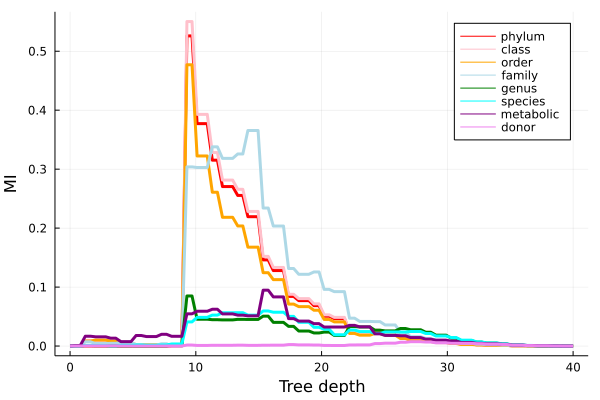

In [12]:
plot(ylabel="MI", xlabel="Tree depth", legend=:topright)
for (tlab, tcol) in zip(taxaranklabels, taxarankcolors)
    df = filter(:curveID=> ==(tlab), plotdf)
    @df df plot!(cuts, :MI, label=tlab, c=tcol, lw=3)
end
plot!()

In [13]:
savefig(joinpath(pdir, "BB673_rawMIcurves.pdf"))

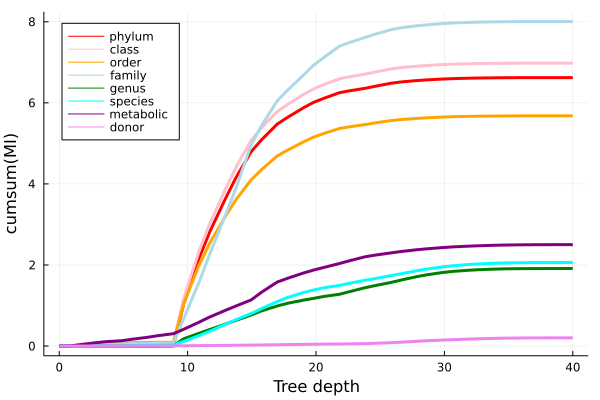

In [14]:
plot(ylabel="cumsum(MI)", xlabel="Tree depth", legend=:topleft)
for (tlab, tcol) in zip(taxaranklabels, taxarankcolors)
    df = filter(:curveID=> ==(tlab), plotdf)
    @df df plot!(cuts, cumsum(:MI), label=tlab, c=tcol, lw=3)
end
plot!()

In [15]:
savefig(joinpath(pdir, "BB673_cumMIcurves.pdf"))

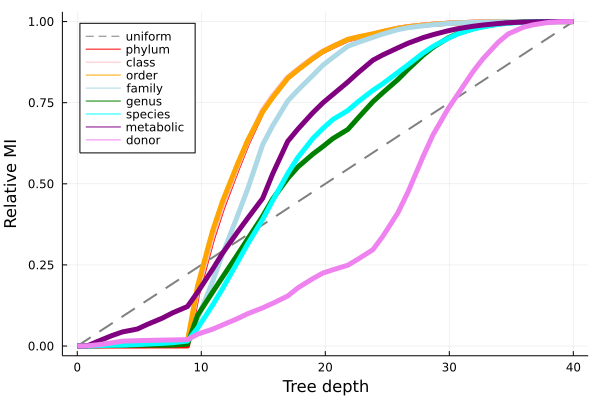

In [16]:
plot(ylabel="Relative MI", xlabel="Tree depth", legend=:topleft)
plot!([0,last(cuts)], [0, 1], linestyle=:dash, c=:grey, lw=2, label="uniform")
for (tlab, tcol) in zip(taxaranklabels, taxarankcolors)
    df = filter(:curveID=> ==(tlab), plotdf)
    @df df plot!(cuts, scaledcumsum(:MI), label=tlab, c=tcol, lw=5)
end
plot!()

In [17]:
savefig(joinpath(pdir, "BB673_relMIcurves.pdf"))

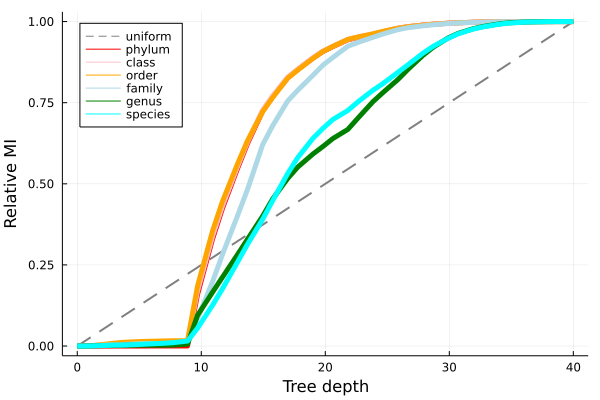

In [18]:
plot(ylabel="Relative MI", xlabel="Tree depth", legend=:topleft)
plot!([0,last(cuts)], [0, 1], linestyle=:dash, c=:grey, lw=2, label="uniform")
for (tlab, tcol) in zip(taxaranklabels, taxarankcolors)
    tlab ∈ ["metabolic", "donor"] && continue
    df = filter(:curveID=> ==(tlab), plotdf)
    @df df plot!(cuts, scaledcumsum(:MI), label=tlab, c=tcol, lw=5)
end
plot!()

In [19]:
savefig(joinpath(pdir, "BB673_relMIcurves_ncbionly.pdf"))

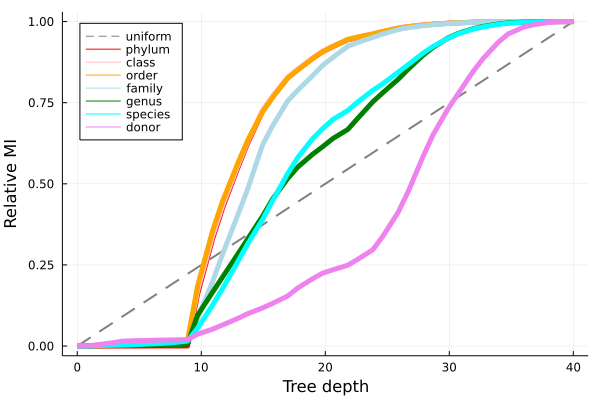

In [20]:
plot(ylabel="Relative MI", xlabel="Tree depth", legend=:topleft)
plot!([0,last(cuts)], [0, 1], linestyle=:dash, c=:grey, lw=2, label="uniform")
for (tlab, tcol) in zip(taxaranklabels, taxarankcolors)
    tlab ∈ ["metabolic"] && continue
    df = filter(:curveID=> ==(tlab), plotdf)
    @df df plot!(cuts, scaledcumsum(:MI), label=tlab, c=tcol, lw=5)
end
plot!()

In [21]:
savefig(joinpath(pdir, "BB673_relMIcurves_ncbianddonoronly.pdf"))

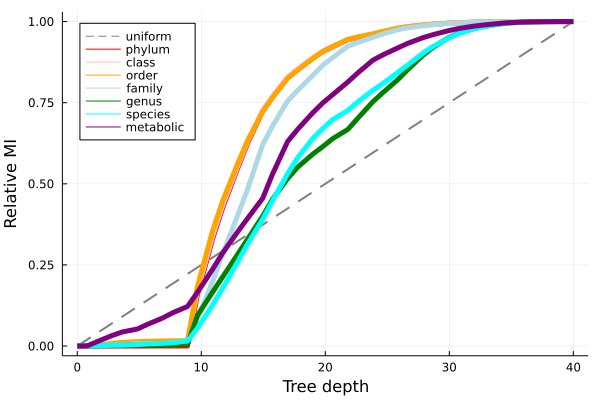

In [22]:
plot(ylabel="Relative MI", xlabel="Tree depth", legend=:topleft)
plot!([0,last(cuts)], [0, 1], linestyle=:dash, c=:grey, lw=2, label="uniform")
for (tlab, tcol) in zip(taxaranklabels, taxarankcolors)
    tlab ∈ ["donor"] && continue
    df = filter(:curveID=> ==(tlab), plotdf)
    @df df plot!(cuts, scaledcumsum(:MI), label=tlab, c=tcol, lw=5)
end
plot!()

In [23]:
savefig(joinpath(pdir, "BB673_relMIcurves_ncbiandmetaboliconly.pdf"))